In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

In [2]:
matplotlib.rcParams.update({'font.size': 14})

In [3]:
cdfparam = dict({'A':0.4137 , 'tau1':0.9 , 'tau2':0.76, 'b':24 })

In [4]:
def SJK_CDF(t):
    A = cdfparam['A']
    b = cdfparam['b']
    tau1 = cdfparam['tau1']
    tau2 = cdfparam['tau2']
    return A*(1.0-np.exp(-t/tau1) + np.exp((t-b)/tau2))

def Expon_CDF(t):
    lamb = 1/24.0 
    return (1.0 - np.exp(-lamb*t))


In [5]:
func_approx_4_param_expon(24.3)

NameError: name 'func_approx_4_param_expon' is not defined

In [6]:
def job_fail_prob(job_len, start_time):
    p_fail = 0.0
    end_time = job_len + start_time 
    if end_time > 24.3:
        p_fail = 1.0 
        return p_fail 
    p_fail = SJK_CDF(end_time) - SJK_CDF(start_time)
    return p_fail 

In [7]:
def smart_job_fail_prob(job_len, start_time):
    p_fail = 0.0
    end_time = job_len + start_time 
    if end_time > 24.3:
        #start a new one for sure 
        p_fail_new = SJK_CDF(job_len) - SJK_CDF(0)
        return p_fail_new
    else:
        p_fail_old = SJK_CDF(end_time) - SJK_CDF(start_time)
        p_fail_new = SJK_CDF(job_len) - SJK_CDF(0)
        return min(p_fail_new, p_fail_old)

In [8]:
smart_job_fail_prob(8, 16.7)

0.4136429457683769

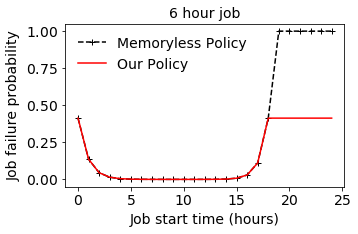

In [53]:
plt.plot([job_fail_prob(6,s) for s in range(0,25)], ls='--', color='k', marker='+', label="Memoryless Policy")
plt.plot([smart_job_fail_prob(6,s) for s in range(0,25)], color='r', label="Our Policy")
plt.legend(loc='best', frameon=False)
plt.xlabel("Job start time (hours)")
plt.ylabel("Job failure probability")
plt.title("6 hour job",fontsize=14)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(5, 3)
plt.savefig("../graphs/Sched-bathtub.pdf",bbox_inches='tight')

In [19]:
def avg_fail_prob(job_len):
    return np.mean([job_fail_prob(job_len, s) for s in range(0,24)])

def smart_avg_fail_prob(job_len):
    return np.mean([smart_job_fail_prob(job_len, s) for s in range(0,24)])

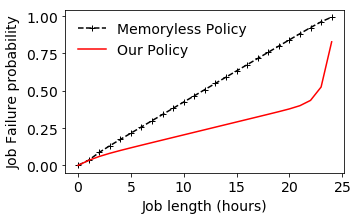

In [54]:
plt.plot([avg_fail_prob(job_len) for job_len in range(0,25)], ls='--', color='k', marker='+' , label="Memoryless Policy")
plt.plot([smart_avg_fail_prob(job_len) for job_len in range(0,25)], color='r', label="Our Policy")
plt.legend(frameon=False)
plt.xlabel("Job length (hours)")
plt.ylabel("Job Failure probability")
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(5, 3)
plt.savefig("../graphs/Sched-fail-prob.pdf", bbox_inches='tight')

# Comparing Bathtub vs. Uniform CDF for expected job recomputation time

In [21]:
def exp_wasted(job_len, CDF_type):
    if CDF_type is "SJK":
        fail_prob = job_fail_prob_SJK(job_len, 0)
    else: 
        fail_prob = job_fail_prob_UNIFORM(job_len, 0)

    # We want \sum^joblen {P(x)*x}  
    
    return fail_prob


In [22]:
def job_fail_prob_SJK(job_len, start_time):
    p_fail = 0.0
    end_time = job_len + start_time 
    if end_time > 24.3:
        p_fail = 1.0 
        return p_fail 
    p_fail = SJK_CDF(end_time) - SJK_CDF(start_time)
    return p_fail 

In [23]:
def job_fail_prob_UNIFORM(job_len, start_time):
    p_fail = min(job_len/24.0, 1.0)
    return p_fail 

In [24]:
def wasted_UNIFORM(job_len):
    #Area of the triangle (0,0) (joblen,0) (joblen,CDF(joblen))
    #y = job_len/24.0 
    #return y * 0.5 * job_len 
    return job_len/2.0 #Wasted given there is a single failure 

In [25]:
wasted_UNIFORM(6)

3.0

In [26]:
def func_approx_4_param_expon_exp(t, A, b, tau1, tau2):
    return t*A*((np.exp(-t/tau1)/tau1) + (np.exp((t-b)/tau2))/tau2)    

In [27]:
def expected_paper(t):
    A = cdfparam['A']
    tau1 = cdfparam['tau1']
    tau2 = cdfparam['tau2']
    b = cdfparam['b']
    return -A*(t+tau1)*np.exp(-t/tau1) + A*(t-tau2)*np.exp((t-b)/tau2)

In [28]:
def wasted_SJK(job_len):
    return (expected_paper(job_len) - expected_paper(0))/SJK_CDF(job_len)

In [29]:
wasted_SJK(1)

0.40925827872289094

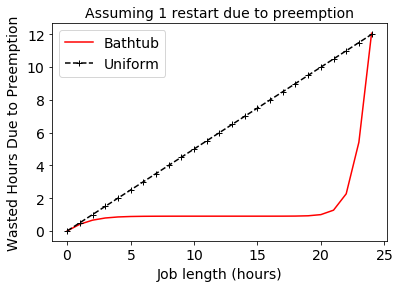

In [59]:
plt.plot([wasted_SJK(jlen) for jlen in range(0,25)], label="Bathtub", color='r')
plt.plot([wasted_UNIFORM(jlen) for jlen in range(0,25)], label="Uniform", ls='--', marker='+',  color='k')
plt.legend()
plt.xlabel("Job length (hours)")
plt.ylabel("Wasted Hours Due to Preemption")
plt.title("Assuming 1 restart due to preemption", fontsize=14)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(6, 4)
plt.savefig("../graphs/uniform-v-bathtub.pdf", bbox_inches='tight')

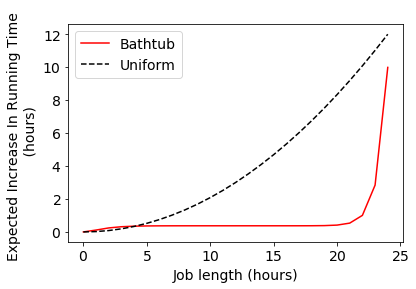

In [60]:
plt.plot([wasted_SJK(jlen)*job_fail_prob_SJK(jlen, 0) for jlen in range(0,25)], label="Bathtub", color='r')
plt.plot([wasted_UNIFORM(jlen)*job_fail_prob_UNIFORM(jlen,0) for jlen in range(0,25)], ls='--', label="Uniform", color='k')
plt.legend()
plt.xlabel("Job length (hours)")
plt.ylabel("Expected Increase In Running Time \n (hours)")
#plt.title("Waste*P(1 failure)")
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(6, 4)
plt.savefig("../graphs/uniform-v-bathtub-2.pdf", bbox_inches='tight')